# **Time Series and Forecasting - Final Project**
| Matheus Hirakawa Bissacot (up202106708) |
Bernardo Gil Alves Salgado (up202004493) |
Michal Dawid Kowalski (up202401554) |

## 1. Uploading Dataset

**Dataset:** 'Hourly Energy Consumption' link: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data

**Brief:** Over 10 years of hourly energy consumption data from PJM in Megawatts. 

**Characterisitcs:** PJM Hourly Energy Consumption Data.

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.fft import fft, fftfreq
from scipy.signal import periodogram
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
from pandas import to_datetime
import pmdarima as pm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

- Electricity usage for the **American Electric Power**

In [2]:
# Upload dataset AEP_hourly.csv
df_aep = pd.read_csv('archive/AEP_hourly.csv')

df_aep.set_index('Datetime', inplace =True) # Set datatime as the Dataframe index
df_aep.index = pd.to_datetime(df_aep.index) # Datatime format
df_aep = df_aep.sort_index() # Sort indexes

In [3]:
df_aep.head(5) # Display first 5 rows

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [4]:
df_aep.info() # Basic Dataset info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [5]:
# Check the time range
min_time = df_aep.index.min()
max_time = df_aep.index.max()
print ('Time range:\n')
print(f" Start Time: {min_time}")
print(f" End Time: {max_time}")
print(f" Time Range: {max_time - min_time}")

Time range:

 Start Time: 2004-10-01 01:00:00
 End Time: 2018-08-03 00:00:00
 Time Range: 5053 days 23:00:00


In [6]:
# Missing values checker
df_aep.isna().sum()

AEP_MW    0
dtype: int64

- **No missing** values in the dataset.

In [7]:
df_aep.describe() # Statistical Characteristics

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


## 2. Data Visualisation & Features Extraction

In this section, we carry out the dataset visualization which is a critical step in time series analysis. It helps us understand the nature of the data and identify key patterns or characteristics.

### 2.1 Diagrams

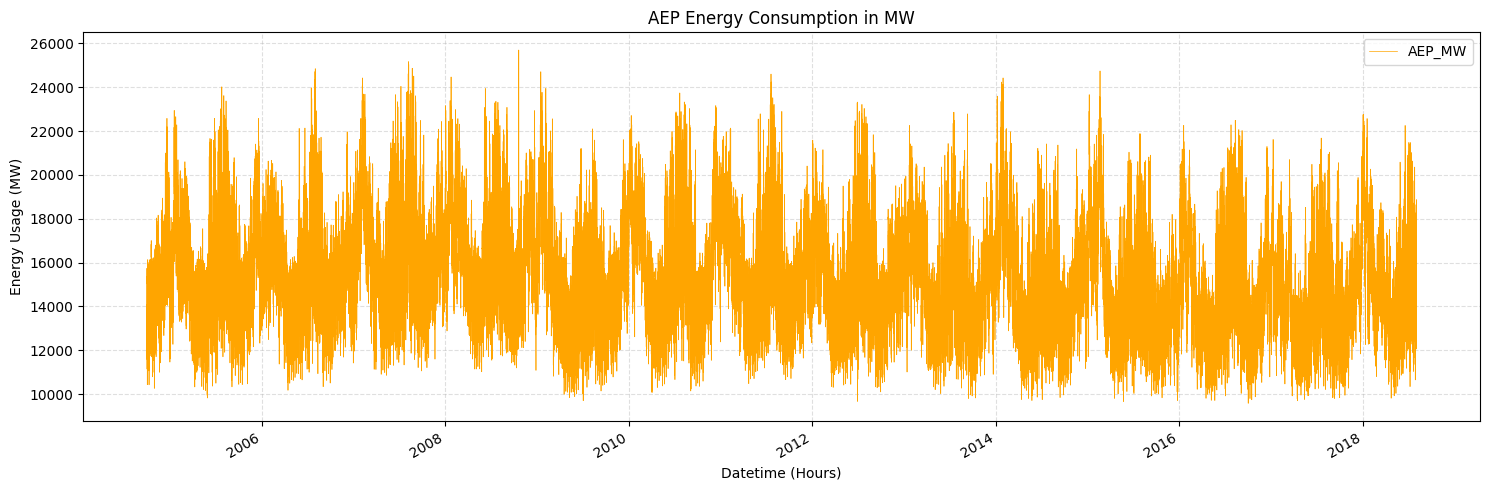

In [8]:
# Timeserie diagram
df_aep.plot(
    figsize=(15, 5),
    color='orange',
    linewidth=0.5,
    title='AEP Energy Consumption in MW',
    xlabel='Datetime (Hours)',
    ylabel='Energy Usage (MW)'
)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

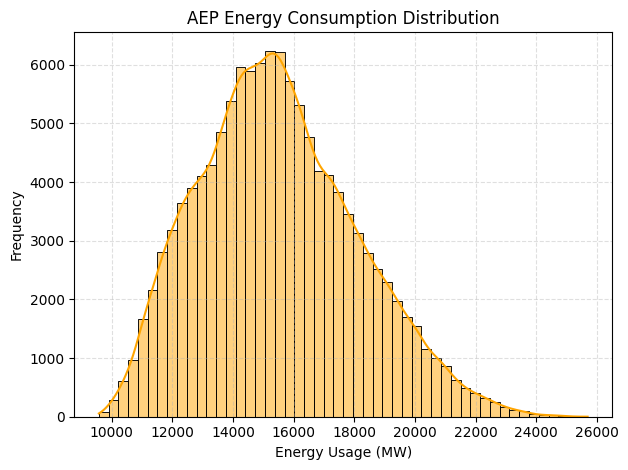

In [9]:
# Energy Usage Distribution
sns.histplot(
    data=df_aep, 
    x='AEP_MW', 
    kde=True, 
    bins=50, 
    color='orange', 
)

plt.title('AEP Energy Consumption Distribution')
plt.xlabel('Energy Usage (MW)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

- AEP energy consumption is normally distributed, with the highest frequency of consumption between 15,000 and 17,000 MW. The data has a relatively small standard deviation, indicating a consistent level of consumption but it is slightly skewed to the right, suggesting a few instances of very high consumption.

### 2.2 Periodogram Analysis

The purpose is to identify dominant frequencies in a time series, revealing cyclic or seasonal patterns. It works by transforming the time series data into the frequency domain, allowing us to spot repeating cycles or trends over regular intervals. This is useful for detecting underlying periodic behaviors, such as monthly cycles, in the data.

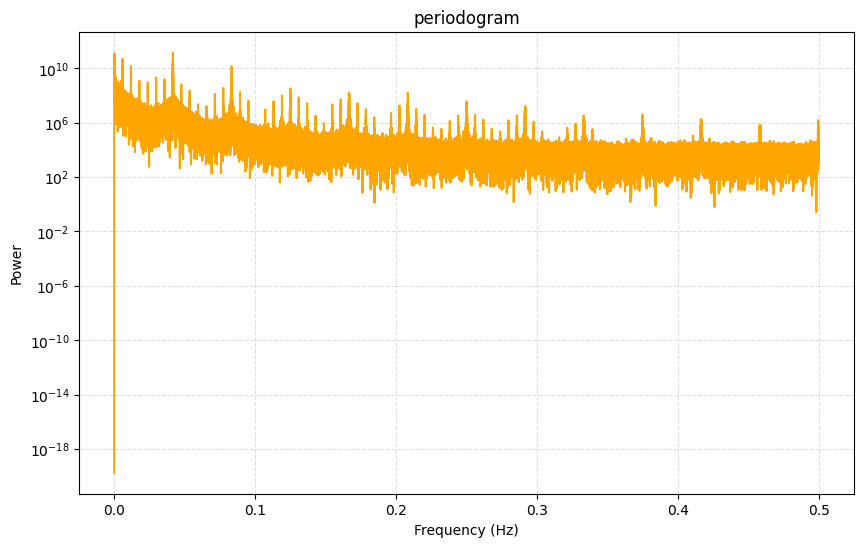

In [10]:
# Compute the periodogram
frequencies, power = periodogram(df_aep['AEP_MW'].dropna(), fs=1)

# Plot the periodogram
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, power, color='orange')
plt.title('periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

- The periodogram displays frequency on the x-axis (in Hertz) and power on the y-axis, showing the strength of signals at each frequency. Peaks indicate significant frequencies, suggesting periodic or seasonal patterns in the time series. While the periodogram doesn’t directly influence ARIMA parameter selection, it highlights trends or seasonality, which may require differencing the data to achieve stationarity before applying ARIMA.

### 2.3 Feature Creation and Analysis

This process involves generating new variables from the time series data to highlight patterns, trends, and seasonality, helping improve model performance by providing more informative inputs. The code adds features such as the hour of the day, day of the week, month, and year to capture time-related information. Additionally, it introduces a season feature, categorizing each month into one of four seasons (spring, summer, autumn, or winter), based on the month values.

In [11]:
df_aep['hour']=df_aep.index.hour     # hours
df_aep['day']=df_aep.index.dayofweek # days, where: 0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thrusday, 4 - Friday, 5 - Saturday, 6 - Sunday
df_aep['month']=df_aep.index.month   # months
df_aep['year']=df_aep.index.year     # years

# Function to get seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 3
    if month in [3, 4, 5]:
        return 0
    if month in [6, 7, 8]:
        return 1
    if month in [9, 10, 11]:
        return 2

df_aep['season'] = df_aep['month'].apply(get_season) # seasons, where: 0 - spring, 1 - summer, 2 - autumn, 3 - winter


In [12]:
df_aep.head(5) # Feautres Display

,AEP_MW,hour,day,month,year,season
Datetime,,,,,,
2004-10-01 01:00:00,12379.0,1,4,10,2004,2
2004-10-01 02:00:00,11935.0,2,4,10,2004,2
2004-10-01 03:00:00,11692.0,3,4,10,2004,2
2004-10-01 04:00:00,11597.0,4,4,10,2004,2
2004-10-01 05:00:00,11681.0,5,4,10,2004,2


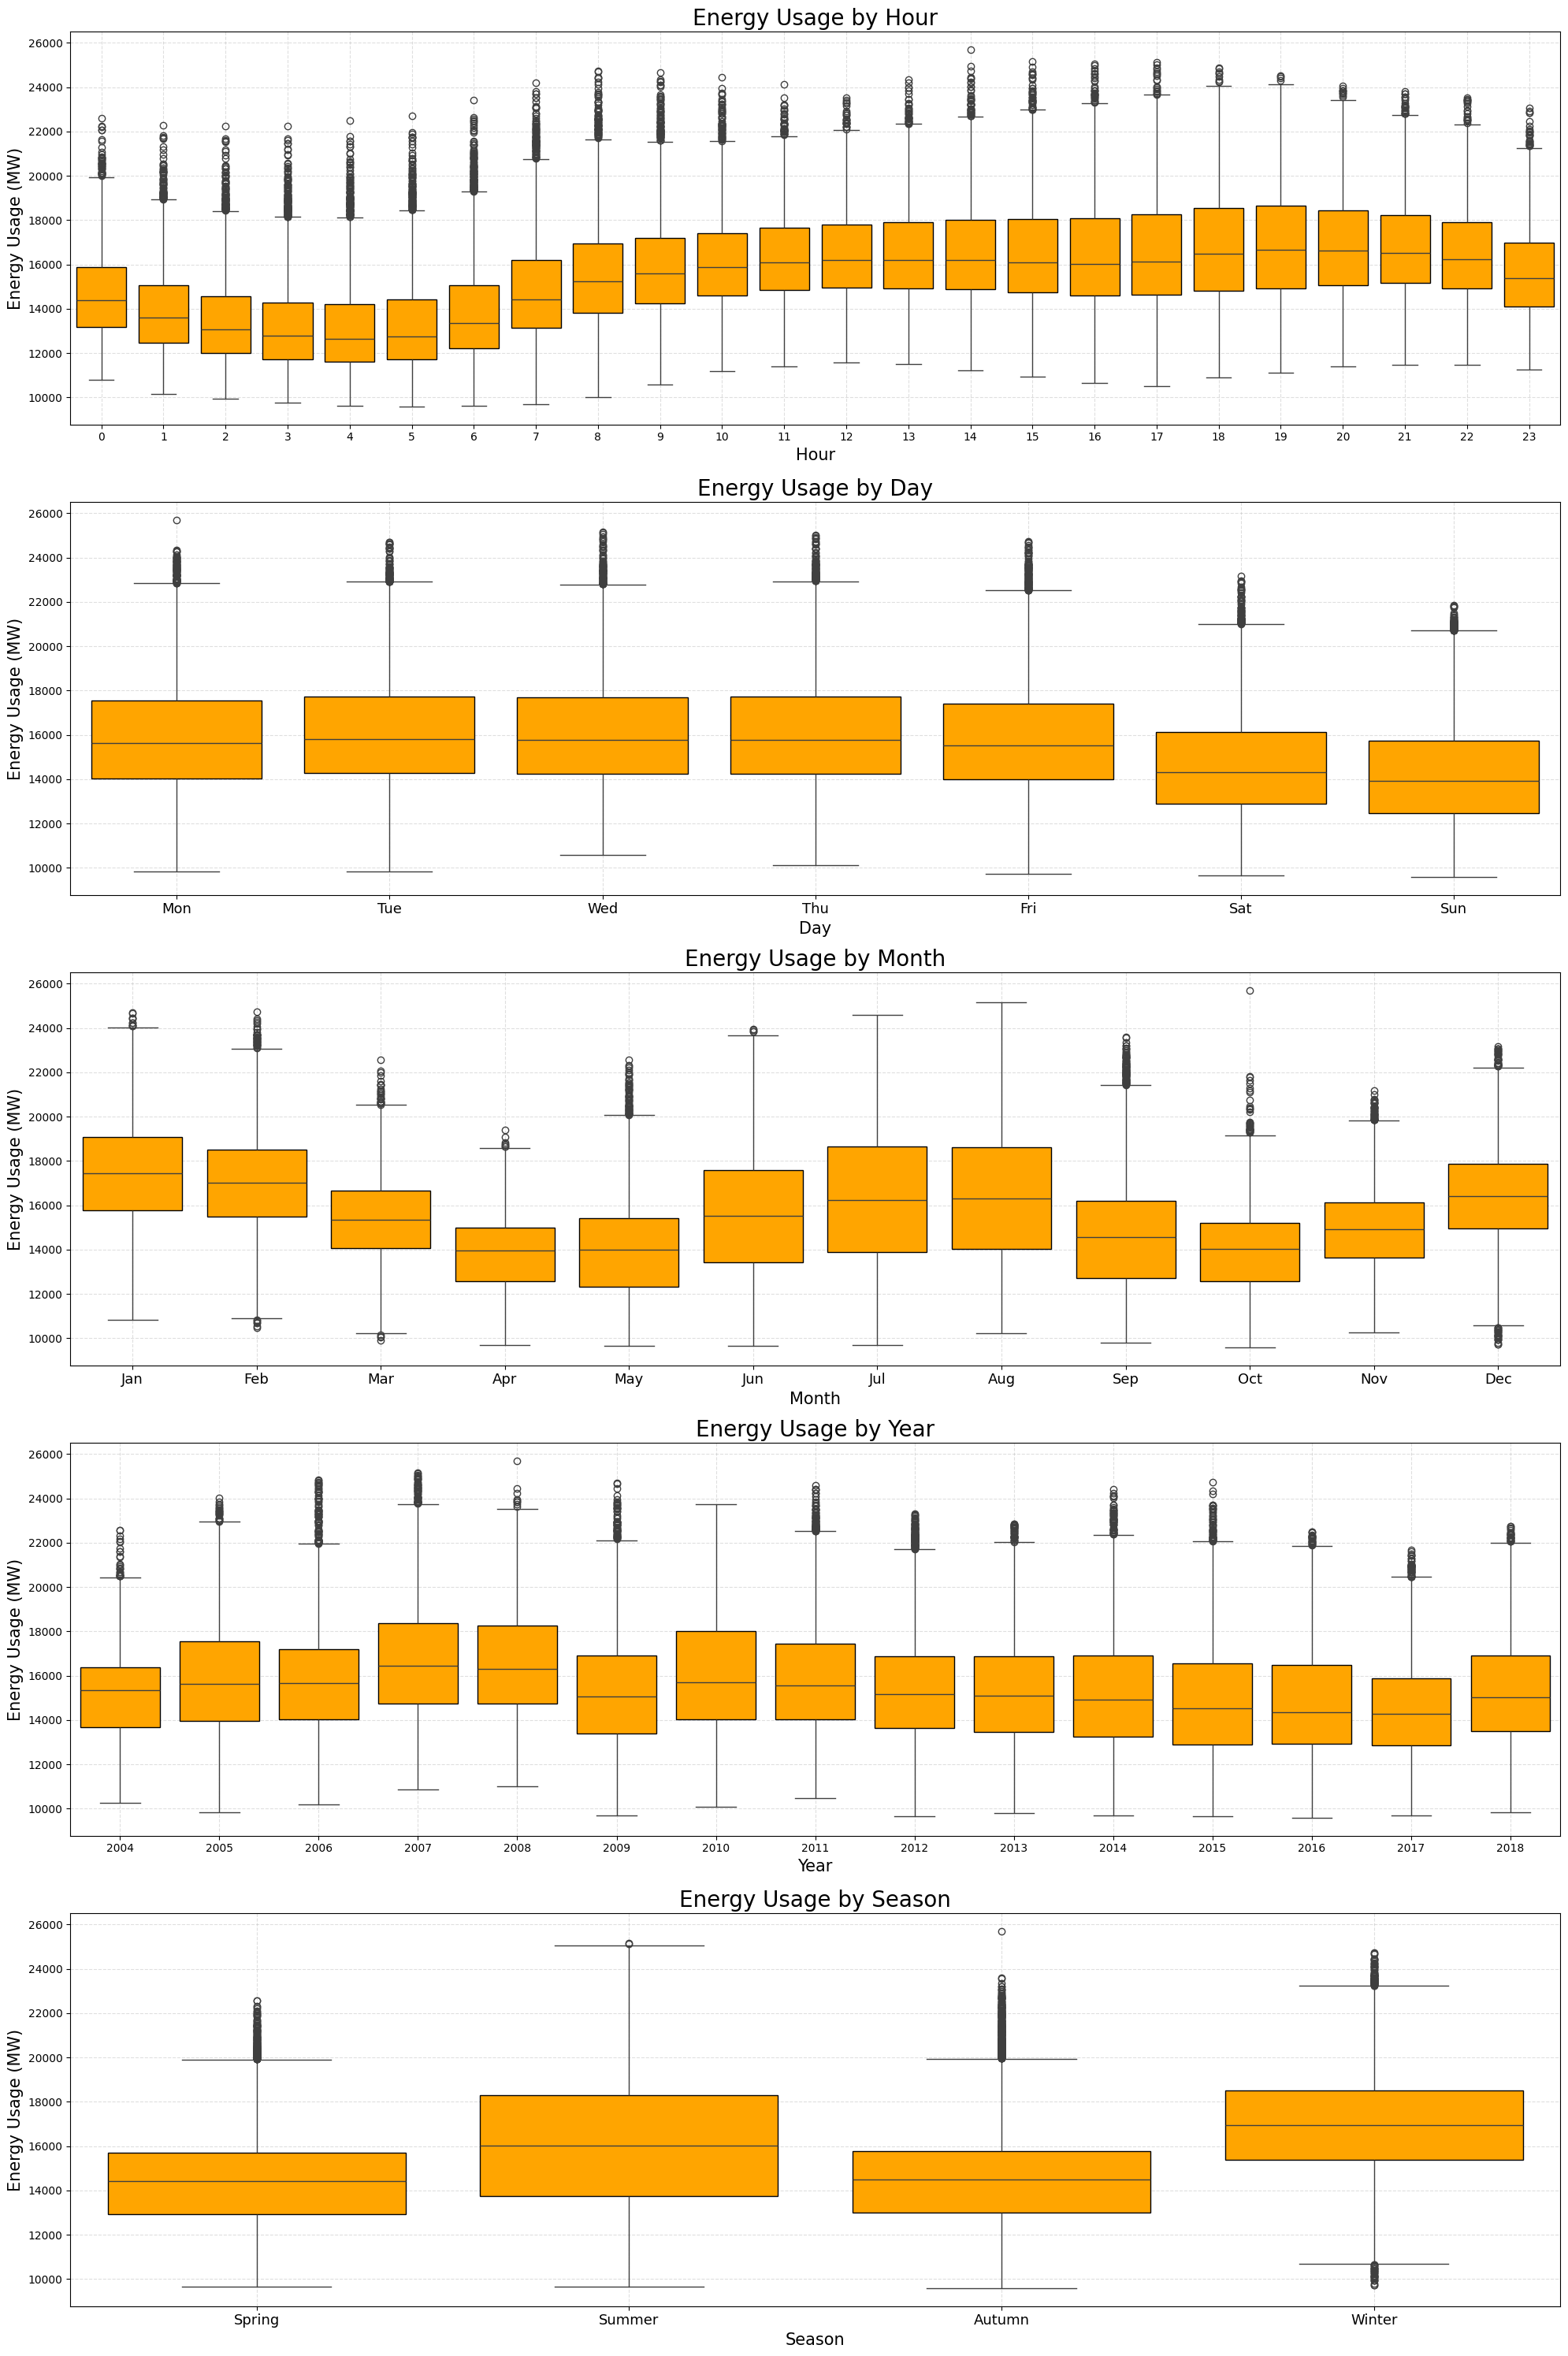

In [13]:
# Boxplots
fig, axes = plt.subplots(5, 1, figsize=(20, 30), sharex=False)

# Energy Usage by Hour
sns.boxplot(data=df_aep, x='hour', y='AEP_MW', ax=axes[0], boxprops=dict(facecolor='orange', edgecolor='black'))
axes[0].set_title('Energy Usage by Hour', fontsize=20)
axes[0].set_xlabel('Hour', fontsize = 15)
axes[0].set_ylabel('Energy Usage (MW)', fontsize = 15)
axes[0].grid(True, linestyle='--', alpha=0.4)

# Energy Usage by Day
sns.boxplot(data=df_aep, x='day', y='AEP_MW', ax=axes[1], boxprops=dict(facecolor='orange', edgecolor='black'))
axes[1].set_title('Energy Usage by Day', fontsize=20)
axes[1].set_xlabel('Day', fontsize = 15)
axes[1].set_ylabel('Energy Usage (MW)', fontsize = 15)
axes[1].set_xticks(range(0, 7))
axes[1].set_xticklabels(
    ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize = 13)
axes[1].grid(True, linestyle='--', alpha=0.4)

# Energy Usage by Month
sns.boxplot(data=df_aep, x='month', y='AEP_MW', ax=axes[2], boxprops=dict(facecolor='orange', edgecolor='black'))
axes[2].set_title('Energy Usage by Month', fontsize=20)
axes[2].set_xlabel('Month', fontsize = 15)
axes[2].set_ylabel('Energy Usage (MW)', fontsize = 15)
axes[2].set_xticks(range(0, 12))
axes[2].set_xticklabels(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize = 13)
axes[2].grid(True, linestyle='--', alpha=0.4)

# Energy Usage by Year
sns.boxplot(data=df_aep, x='year', y='AEP_MW', ax=axes[3], boxprops=dict(facecolor='orange', edgecolor='black'))
axes[3].set_title('Energy Usage by Year', fontsize=20)
axes[3].set_xlabel('Year', fontsize = 15)
axes[3].set_ylabel('Energy Usage (MW)', fontsize = 15)
axes[3].grid(True, linestyle='--', alpha=0.4)

# Energy Usage by Season
sns.boxplot(data=df_aep, x='season', y='AEP_MW', ax=axes[4], boxprops=dict(facecolor='orange', edgecolor='black'))
axes[4].set_title('Energy Usage by Season', fontsize=20)
axes[4].set_xlabel('Season', fontsize = 15)
axes[4].set_ylabel('Energy Usage (MW)', fontsize = 15)
axes[4].set_xticks(range(0, 4))
axes[4].set_xticklabels(
    ['Spring', 'Summer', 'Autumn', 'Winter'], fontsize = 13)
axes[4].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

- **Daily:**
Energy consumption exhibits a clear diurnal pattern. It's lowest during nighttime hours (11 PM - 6 AM) and peaks in the evening (6-7 PM), likely due to residential activities. A midday dip around 3-4 PM suggests reduced energy use before the evening surge.

- **Weekly:**
The box plot reveals slightly lower average energy consumption on weekends compared to weekdays, possibly attributed to changes in lifestyle and reduced residential energy use during leisure activities.

- **Monthly & Seasonal:**
Energy usage peaks in winter (December-February) and summer (June-August) due to heating and cooling needs. Lower consumption occurs in spring (March-May) and autumn (September-November) when milder weather reduces reliance on climate control systems.

- **Yearly:**
The yearly box plot shows variability in energy consumption, potentially influenced by factors like population growth and economic conditions. Further analysis with long-term trends might reveal additional insights.

- Outliers are present across all plots, representing periods of exceptionally high energy consumption. These could correspond to holidays, extreme weather, or system demand spikes. Investigating these anomalies can provide valuable insights into the dataset.

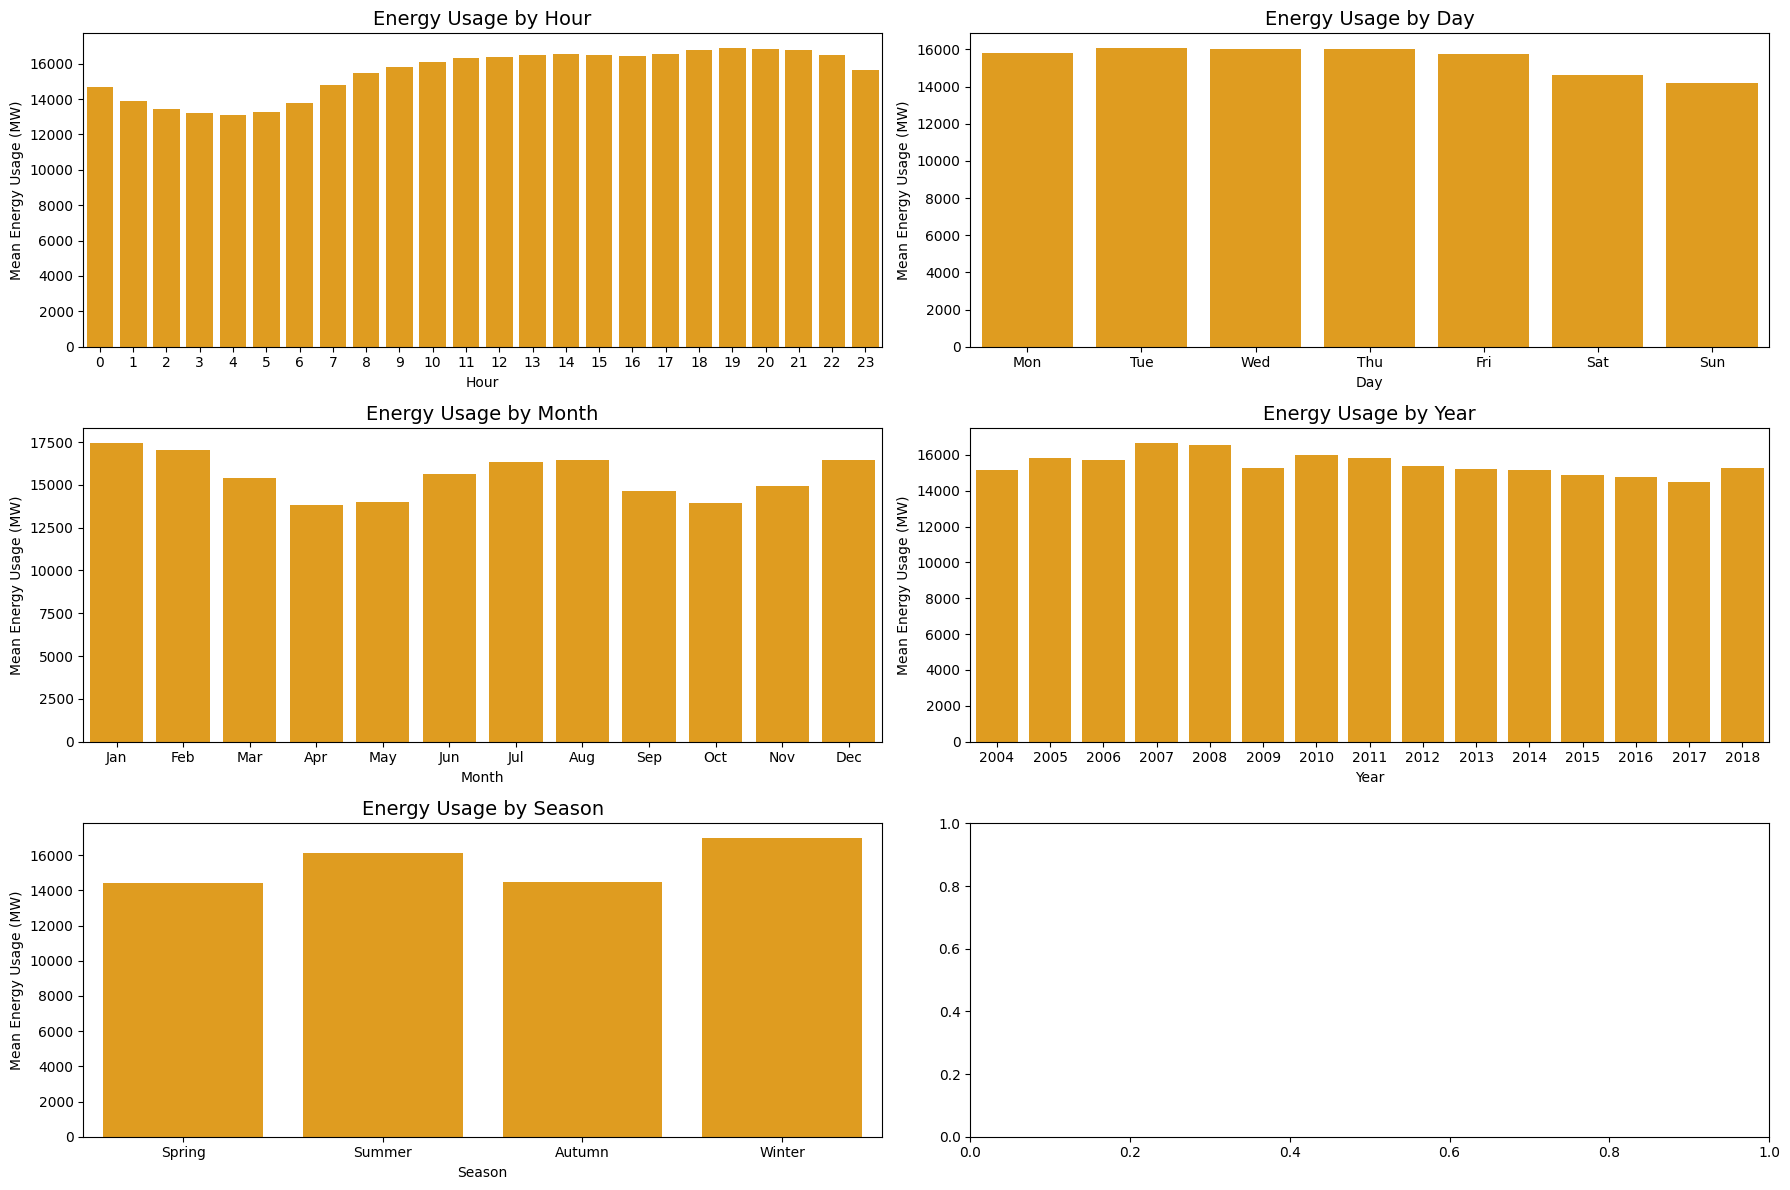

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

sns.barplot(data=df_aep, x='hour', y='AEP_MW', estimator=np.mean, errorbar=None, ax=axes[0], color='orange')
axes[0].set_title('Energy Usage by Hour', fontsize=14)
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Mean Energy Usage (MW)')

sns.barplot(data=df_aep, x='day', y='AEP_MW', estimator=np.mean, errorbar=None, ax=axes[1], color='orange')
axes[1].set_title('Energy Usage by Day', fontsize=14)
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Mean Energy Usage (MW)')
axes[1].set_xticks(range(0, 7))
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


sns.barplot(data=df_aep, x='month', y='AEP_MW', estimator=np.mean, errorbar=None, ax=axes[2], color='orange')
axes[2].set_title('Energy Usage by Month', fontsize=14)
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Mean Energy Usage (MW)')
axes[2].set_xticks(range(0, 12))
axes[2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

sns.barplot(data=df_aep, x='year', y='AEP_MW', estimator=np.mean, errorbar=None, ax=axes[3], color='orange')
axes[3].set_title('Energy Usage by Year', fontsize=14)
axes[3].set_xlabel('Year')
axes[3].set_ylabel('Mean Energy Usage (MW)')

sns.barplot(data=df_aep, x='season', y='AEP_MW', estimator=np.mean, errorbar=None, ax=axes[4], color='orange')
axes[4].set_title('Energy Usage by Season', fontsize=14)
axes[4].set_xlabel('Season')
axes[4].set_ylabel('Mean Energy Usage (MW)')
axes[4].set_xticks([0, 1, 2, 3])
axes[4].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])

plt.tight_layout()
plt.show()

- Above another way to present time series distibution using histograms.

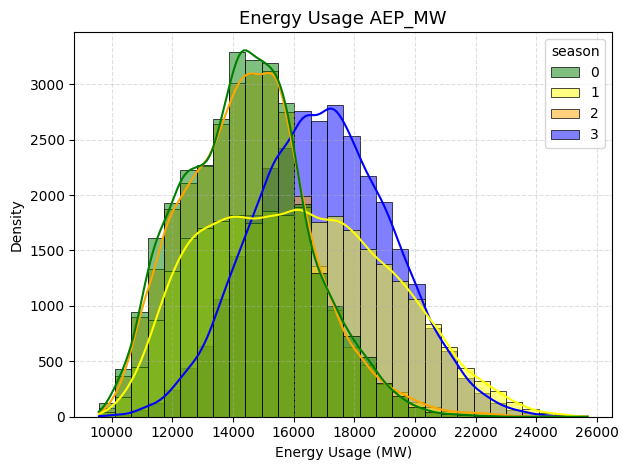

In [15]:
sns.histplot(df_aep[['AEP_MW', 'year', 'season']], 
             x='AEP_MW',
             kde=True,
             bins=30,
             hue='season',
             palette=['green', 'yellow', 'orange', 'blue'],
             alpha=0.5,
             linewidth=0.5)

plt.title('Energy Usage AEP_MW', fontsize=13)
plt.xlabel('Energy Usage (MW)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

- Energy consumption exhibits significant seasonal fluctuations, with the highest levels occurring in winter (heating, shorter daylight time) and slightly lower but similar levels in spring and autumn. Summer consumption is more variable but generally higher than the other seasons (higher AC usage).

### 2.3 Seasonal Component Analysis

Now we need to understand and isolate seasonality of this time series by performing a decomposition using the *seasonal_decompose* function. This splits the time series into four components: 

- Observed: represents the original data 
- Trend: shows long-term movement 
- Seasonal: highlights recurring patterns over a fixed period (e.g., yearly)
- Residual: captures the noise or irregular fluctuations. 

The decomposition helps analyze how these components contribute to the overall behavior of the time series, aiding in better modeling and forecasting.

We also use from now on the monthly data due to computational issues.

In [16]:
# Resample the data to monthly frequency, taking the mean for 'AEP_MW'
monthly_data = df_aep.resample('M').mean()

# You can also group by month and aggregate other columns if needed
monthly_data = df_aep.groupby(df_aep.index.to_period('M')).agg({
    'AEP_MW': 'mean'
})

# Print the result
print(monthly_data)

                AEP_MW
Datetime              
2004-10   13947.537736
2004-11   14830.440278
2004-12   16737.720430
2005-01   17117.088710
2005-02   16496.644345
...                ...
2018-04   13639.244444
2018-05   14117.005376
2018-06   15305.250000
2018-07   15926.622312
2018-08   15406.959184

[167 rows x 1 columns]


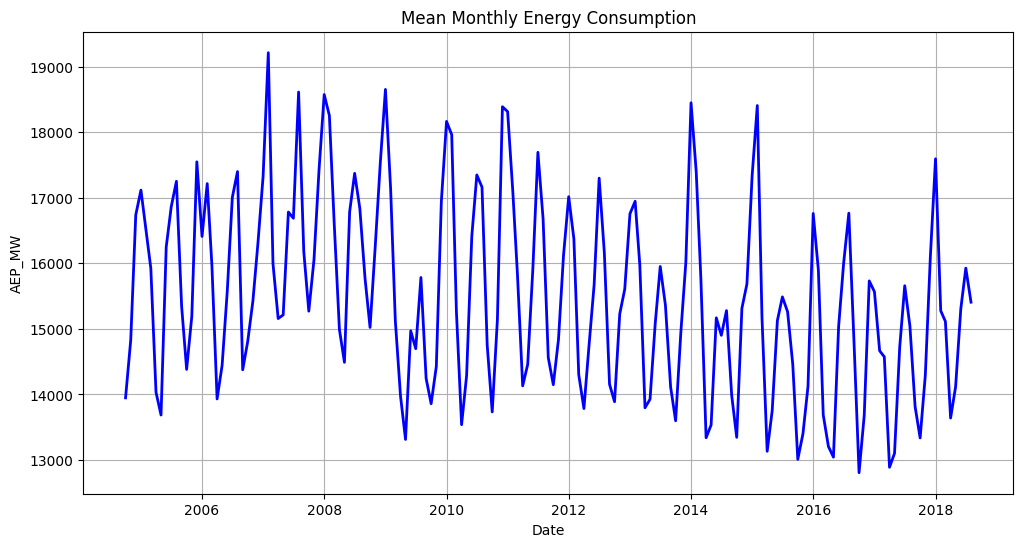

In [17]:
# Convert the PeriodIndex to datetime index
monthly_data.index = monthly_data.index.to_timestamp()

# Now, plot the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['AEP_MW'], linewidth=2, c='blue')
plt.title("Mean Monthly Energy Consumption")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.grid(True)
plt.show()

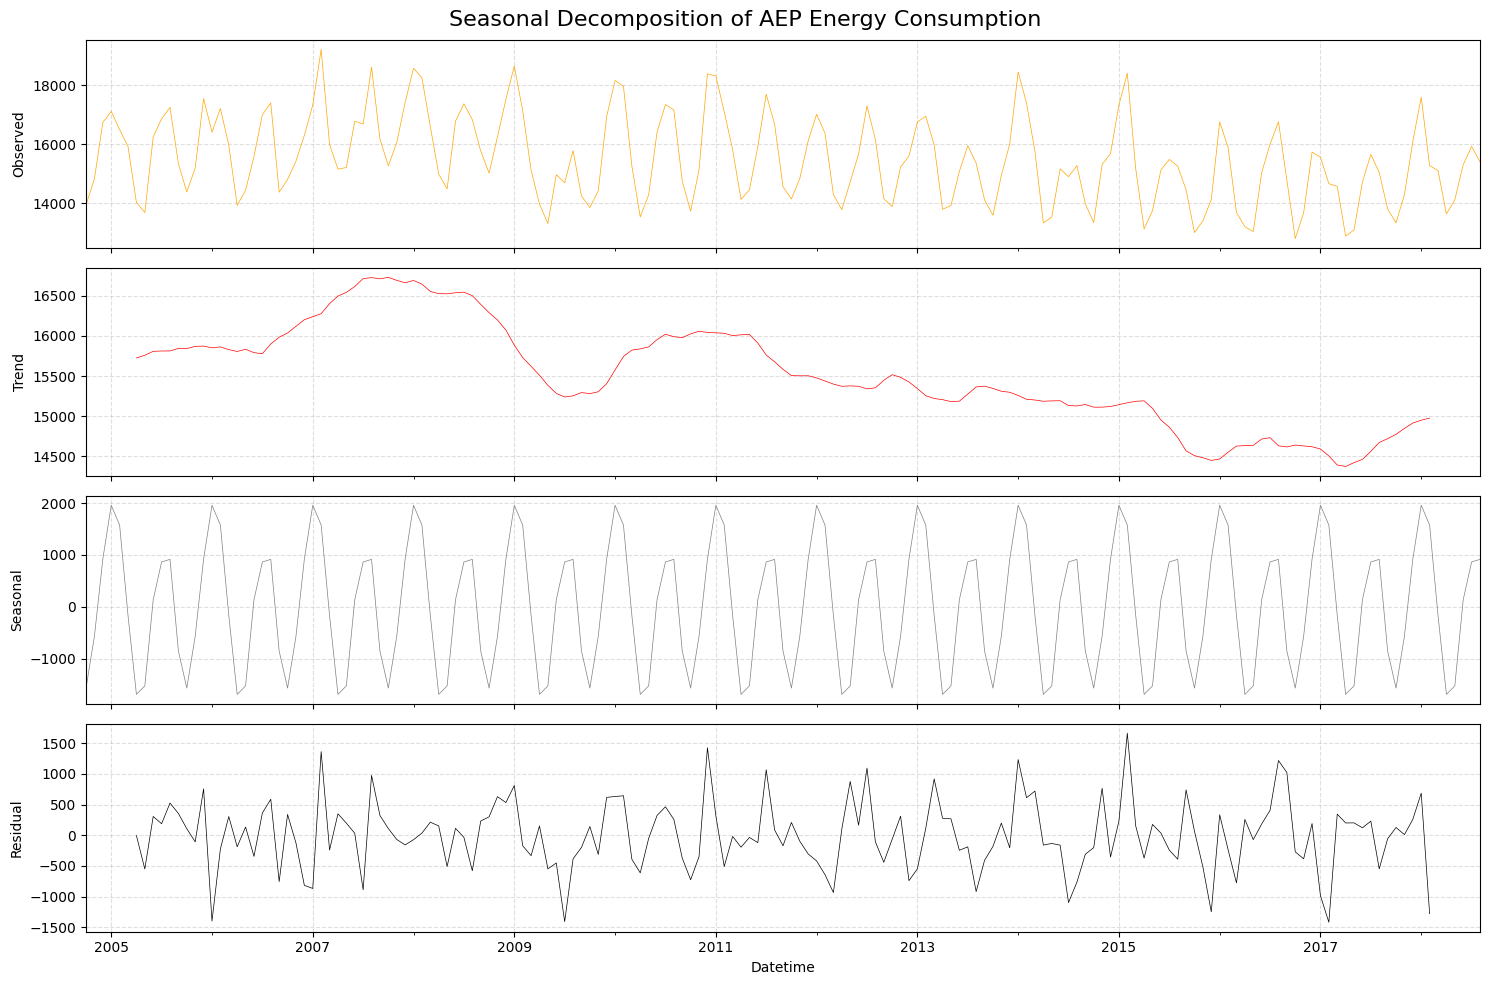

In [18]:
# Datatime Decomposition
result = seasonal_decompose(monthly_data['AEP_MW'], period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

# Observed part
result.observed.plot(ax=axes[0], color='orange', linewidth=0.5)
axes[0].set_ylabel('Observed')
axes[0].grid(True, linestyle='--', alpha=0.4)

# Trend part
result.trend.plot(ax=axes[1], color='red', linewidth=0.5)
axes[1].set_ylabel('Trend')
axes[1].grid(True, linestyle='--', alpha=0.4)

# Seasonal part
result.seasonal.plot(ax=axes[2], color='grey', linewidth=0.5)
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, linestyle='--', alpha=0.4)

# Residual part
result.resid.plot(ax=axes[3], color='black', linewidth=0.5)
axes[3].set_ylabel('Residual')
axes[3].grid(True, linestyle='--', alpha=0.4)

plt.suptitle('Seasonal Decomposition of AEP Energy Consumption', fontsize=16)
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

- **Trend:**
The trend component reveals a gradual increase in energy consumption from 2005 to 2008, followed by a decline until 2013, possibly due to economic factors. After 2013, the trend stabilizes and increases again, suggesting a recovery or growth in energy demand. This analysis highlights key phases in energy consumption, potentially driven by macroeconomic changes.

- **Seasonal Component:**
The seasonal component shows a strong yearly pattern with peaks in specific months, likely due to heating and cooling needs. The amplitude of the seasonal variation remains relatively stable over time, demonstrating the consistent influence of climate on energy usage. This information may be valuable for energy planning and distribution.

- **Residuals:**
The residuals fluctuate around zero, indicating that the model captures most of the data variability. However, some spikes and outliers are present, possibly related to anomalous events or data errors.

### 2.4 Stationarity Check

The next step is to check for stationarity, which is important for time series models like ARIMA. The Augmented Dickey-Fuller (ADF) test helps determine if the time series is stationary by testing the null hypothesis of a unit root. If the p-value is less than or equal to 0.05, we reject the null hypothesis and conclude the series is stationary. If the p-value is greater than 0.05, the series is non-stationary and may need transformation before modeling.

In [19]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] <= 0.05:
        print("Reject the null hypothesis (Stationary)")
    else:
        print("Fail to reject the null hypothesis (Non-stationary)")

adf_test(monthly_data['AEP_MW'])

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

check_stationarity(monthly_data['AEP_MW'])

ADF Statistic: -1.696008676464601
p-value: 0.433170091306491
Critical Values:
   1%: -3.474120870218417
   5%: -2.880749791423677
   10%: -2.5770126333102494
Fail to reject the null hypothesis (Non-stationary)
ADF Statistic: -1.696008676464601
p-value: 0.433170091306491
Non-Stationary


- The p-value of 0.43 means we fail to reject the null hypothesis, indicating the series is non-stationary. The ADF statistic is also higher than the critical values, confirming the data is not stationary.

### 2.5 ACF and PACF Diagrams

We use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify the relationships within a time series. ACF measures the overall correlation between a time series and its lagged values, while PACF isolates the correlation between the series and a specific lag. These plots are essential for determining the order of ARIMA models.

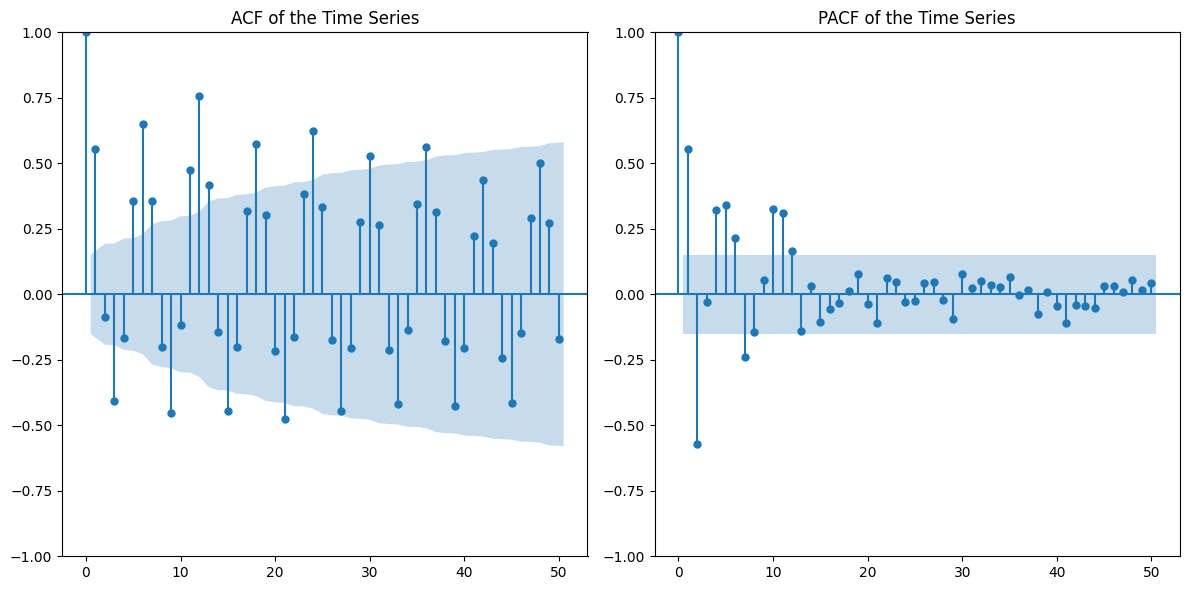

In [20]:
# n for these two graphs
n = 55

# Calculate the threshold for ACF and PACF: +/- 1.96 / sqrt(n)
conf_interval = 1.96 / np.sqrt(n)

plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(121)
plot_acf(monthly_data['AEP_MW'].dropna(), lags=50, ax=plt.gca())
plt.title('ACF of the Time Series')

# PACF plot
plt.subplot(122)
plot_pacf(monthly_data['AEP_MW'].dropna(), lags=50, ax=plt.gca())
plt.title('PACF of the Time Series')

plt.tight_layout()
plt.show()

- The ACF plot shows a significant spike at lag 1, indicating strong autocorrelation, followed by a gradual decay, typical of non-stationary data with lasting influence from past values. Beyond lag 5-6, autocorrelation falls within the confidence interval, becoming statistically insignificant, which aligns with the earlier ADF test results, suggesting non-stationary behavior.
- The PACF plot shows a significant spike at lag 1, indicating a strong correlation with the first lag, followed by smaller, less significant spikes.

## 3. Training & Test Dataset
We split the data into training and test datasets for ARIMA modeling to evaluate the model's ability to generalize and make accurate predictions on unseen data. The training set is used to fit the ARIMA model, while the test set helps assess its forecasting performance and ensure it doesn't overfit.

- **Training dataset**: values before 2016
- **Test dataset**: values after 2016

(After modifying the Time Series, use the same code, but with the modified Time Series)

In [21]:
# Train Test Split
df_train, df_test = monthly_data[monthly_data.index <= '2016'], monthly_data[monthly_data.index >= '2016']

# Calculate percentages
train_size = len(df_train)
test_size = len(df_test)
total_size = train_size + test_size
train_per = (train_size / total_size) * 100
test_per = (test_size / total_size) * 100

print('TRAINING & TEST DATASET\n')
print('Train dataset:', len(df_train), f'({train_per:.2f}%)')
print('Test dataset:', len(df_test), f'({test_per:.2f}%)')

TRAINING & TEST DATASET

Train dataset: 136 (80.95%)
Test dataset: 32 (19.05%)


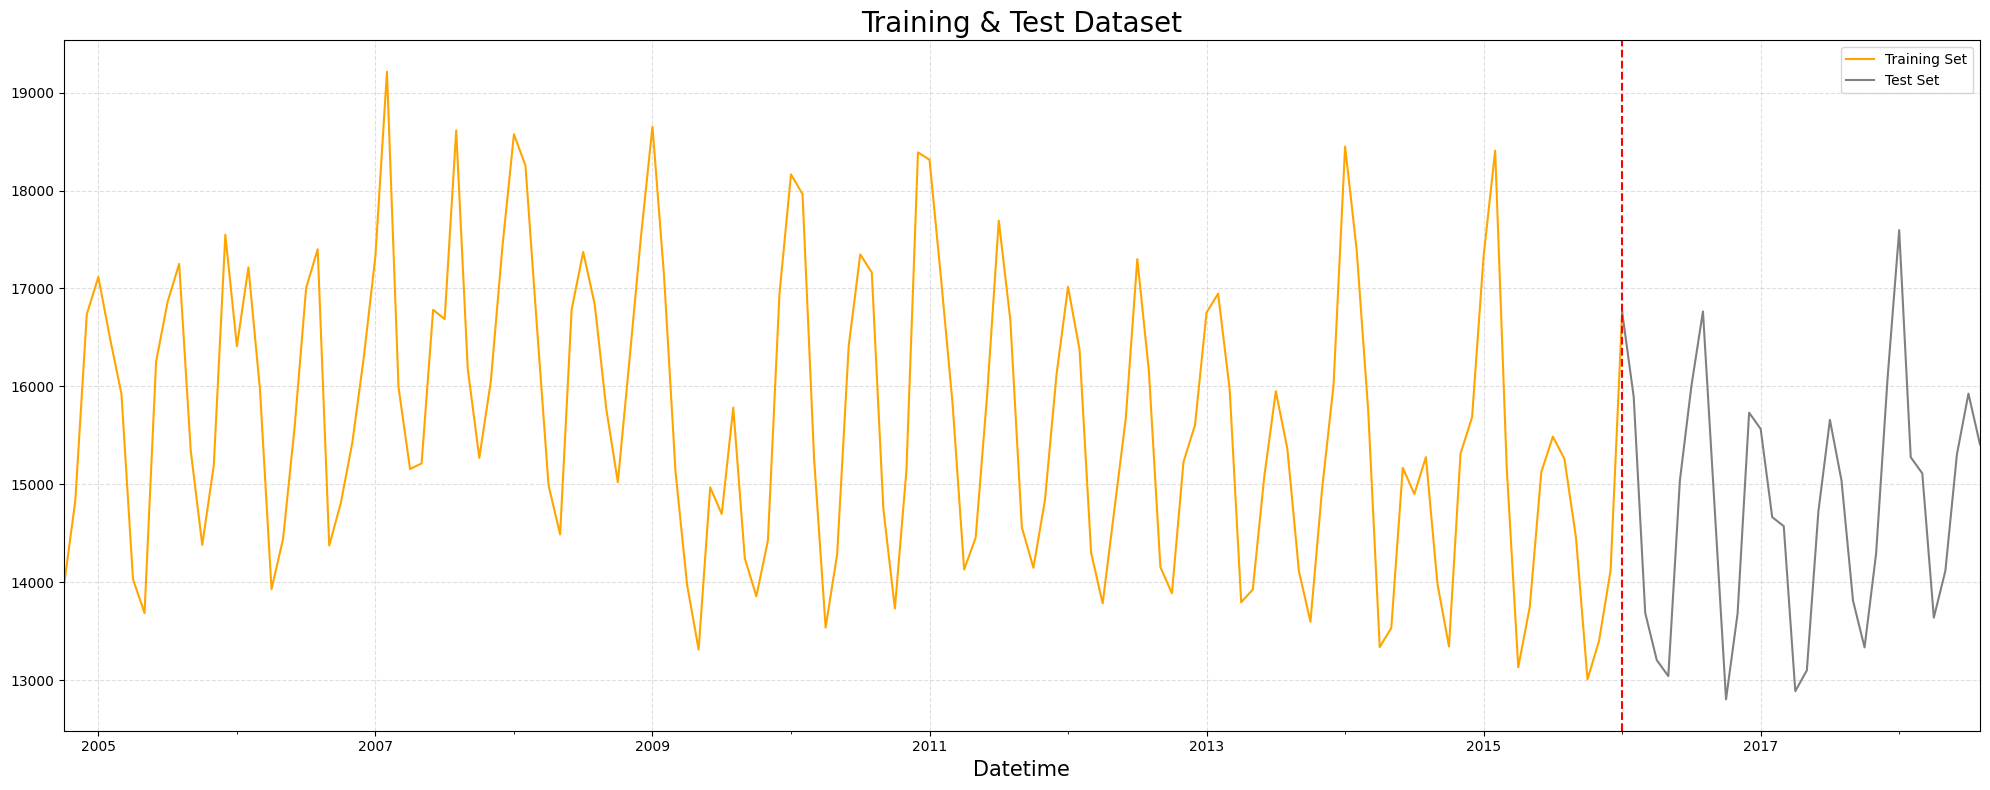

In [22]:
# Display diagram with train/test data
plt.figure(figsize=(20,8))

df_train['AEP_MW'].plot(label='Training Set', color = 'orange')
df_test['AEP_MW'].plot(label='Test Set', color = 'grey')
plt.axvline('2016-01-01', color='red', ls='--', lw=1.5)
plt.title('Training & Test Dataset', fontsize=20)
plt.xlabel('Datetime', fontsize = 15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 4. Models Build and Evaluation
In this step, we build ARIMA and SARIMA models to forecast the time series data. The process involves selecting the appropriate model, fitting it to the data, and generating predictions. We then evaluate the forecast accuracy using metrics to assess how well the models capture the underlying patterns in the data.
### 4.1 ARIMA Model Implementation

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2342.805, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2276.903, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2304.152, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2340.838, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2337.237, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2261.415, Time=0.38 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2263.657, Time=1.01 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2253.196, Time=0.39 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2305.410, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2255.285, Time=0.79 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2282.937, Time=0.34 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2253.216, Time=0.32 sec
 ARIMA(2,1,0)(1,0,1)[12] inte

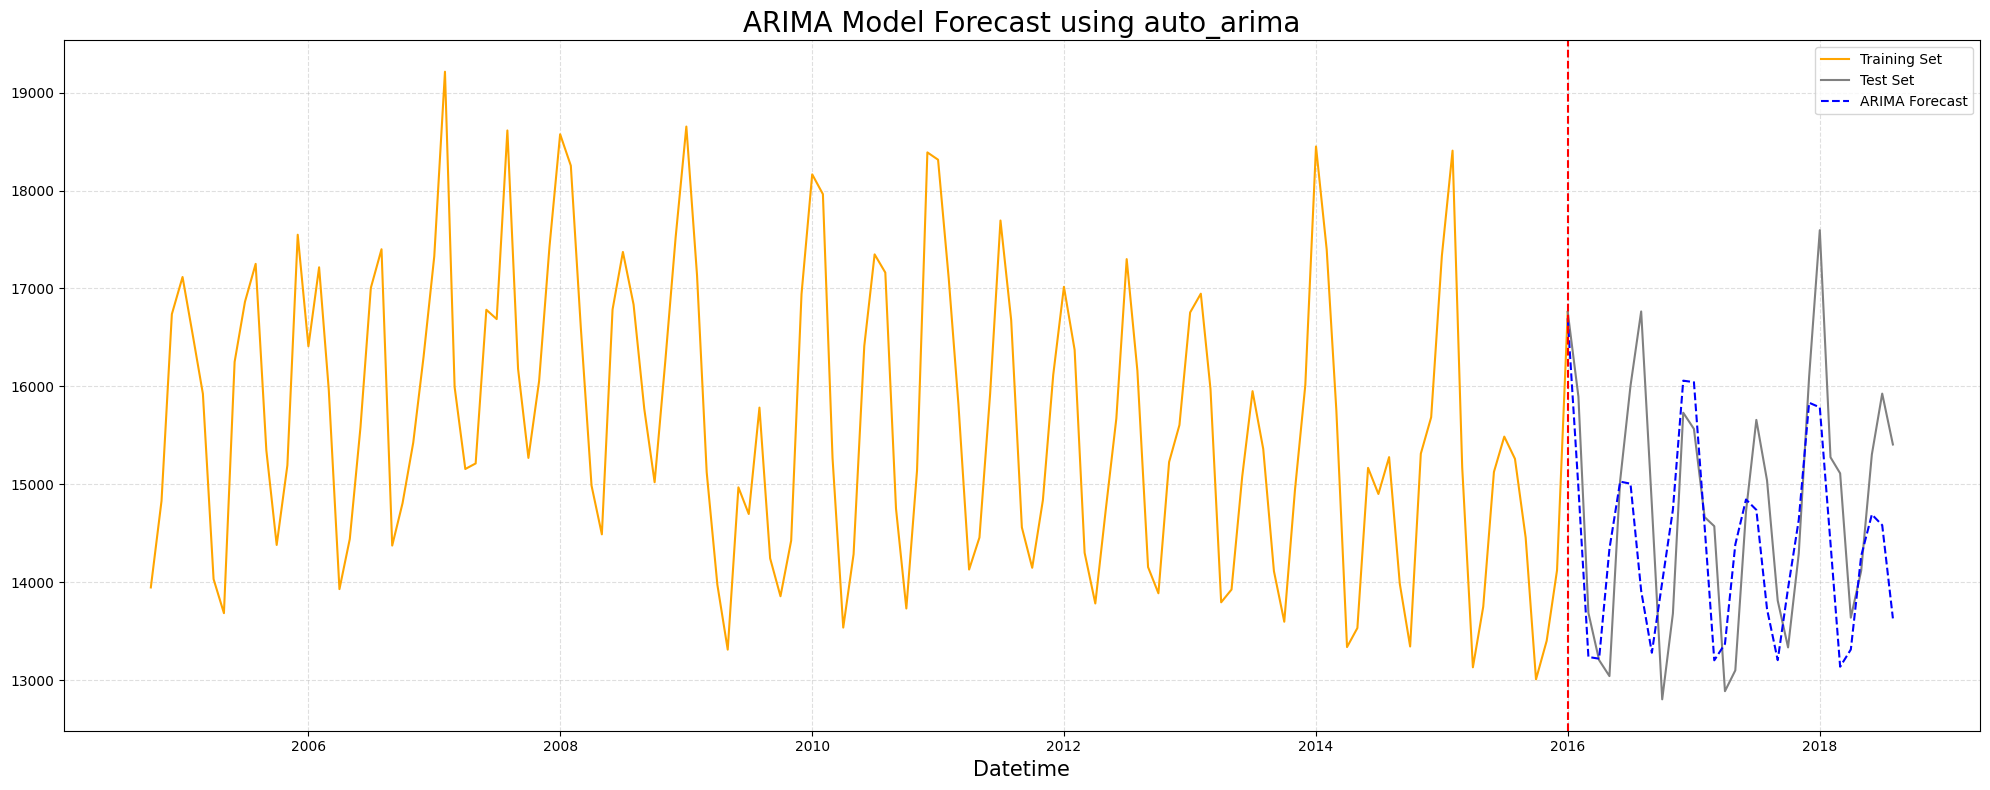

In [23]:
# Ensure no SettingWithCopyWarning
df_train = df_train.copy()  # Optional: if df_train is a slice of a larger DataFrame
df_train['AEP_MW'] = df_train['AEP_MW'].fillna(method='ffill')

# Fit ARIMA model using auto_arima
model = pm.auto_arima(df_train['AEP_MW'], seasonal=True, m=12, stepwise=True, trace=True)

# Show the summary of the best model
print(model.summary())

# Forecast the future values
forecast = model.predict(n_periods=len(df_test))

# Plot the predictions along with the actual values
plt.figure(figsize=(20, 8))
plt.plot(df_train['AEP_MW'], label='Training Set', color='orange')
plt.plot(df_test['AEP_MW'], label='Test Set', color='grey')
plt.plot(df_test.index, forecast, label='ARIMA Forecast', color='blue', linestyle='--')
plt.axvline(pd.to_datetime('2016-01-01'), color='red', ls='--', lw=1.5)
plt.title('ARIMA Model Forecast using auto_arima', fontsize=20)
plt.xlabel('Datetime', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


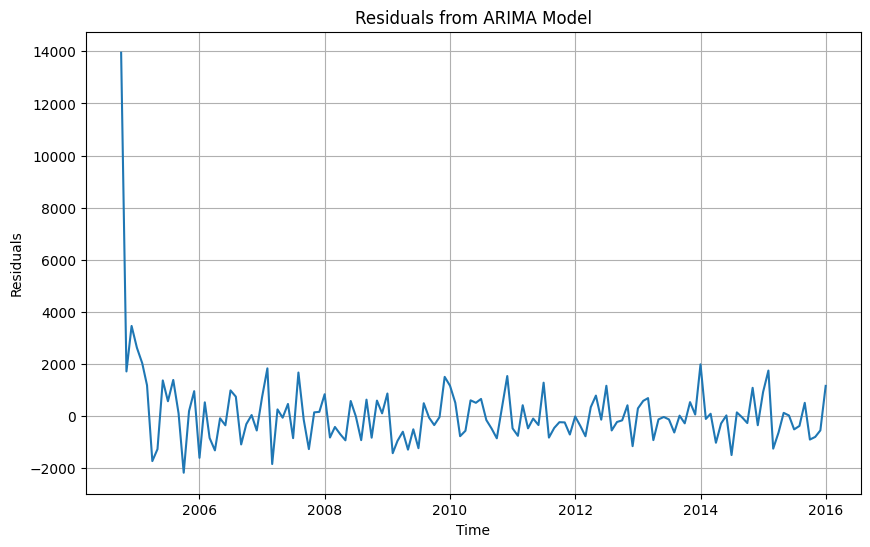

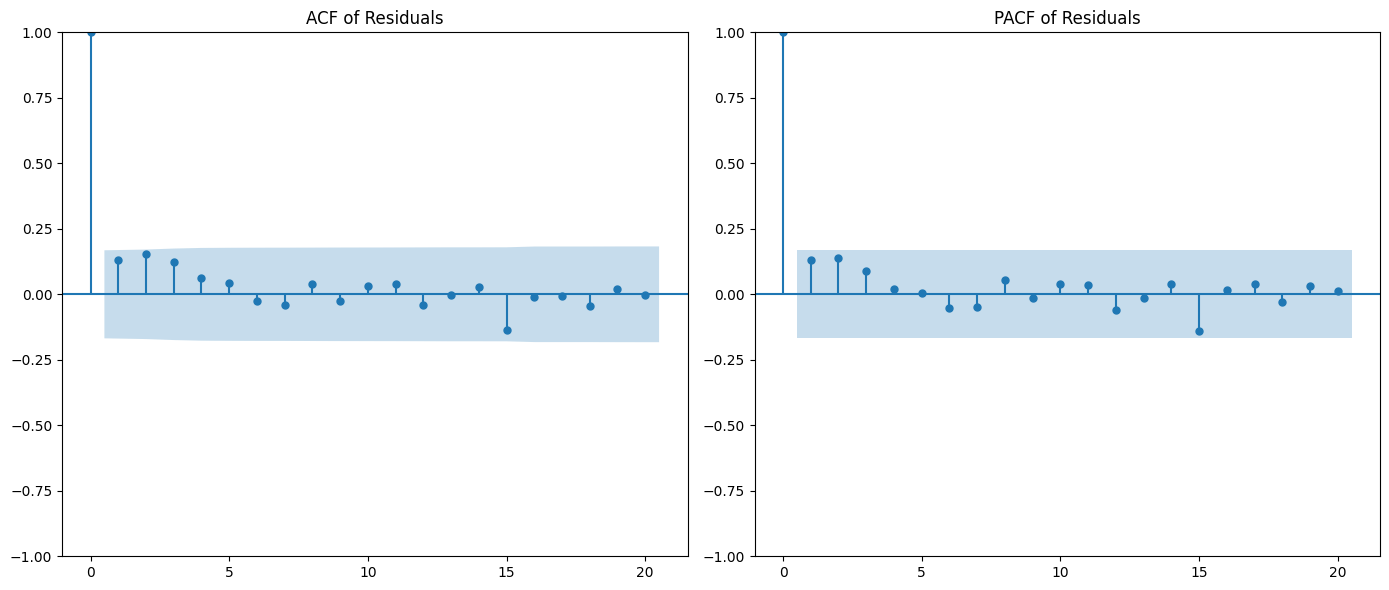


Ljung-Box Test Results:
     lb_stat  lb_pvalue
10  9.293024   0.025638


In [24]:
# Ljung-Box test on residuals
residuals = model.resid()  # Get residuals from the model

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(residuals.dropna(), lags=20, ax=axes[0])
axes[0].set_title('ACF of Residuals')
plot_pacf(residuals.dropna(), lags=20, ax=axes[1])
axes[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10], model_df=7, return_df=True) # Test for autocorrelation up to lag 15
print("\nLjung-Box Test Results:")
print(lb_test)

### 4.2 SARIMA Model Implementation

                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:                  136
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -873.422
Date:                            Fri, 03 Jan 2025   AIC                           1756.843
Time:                                    22:51:22   BIC                           1770.300
Sample:                                10-01-2004   HQIC                          1762.301
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2947      0.134      2.192      0.028       0.031       0.558
ma.L1         -0.8310      0.088   

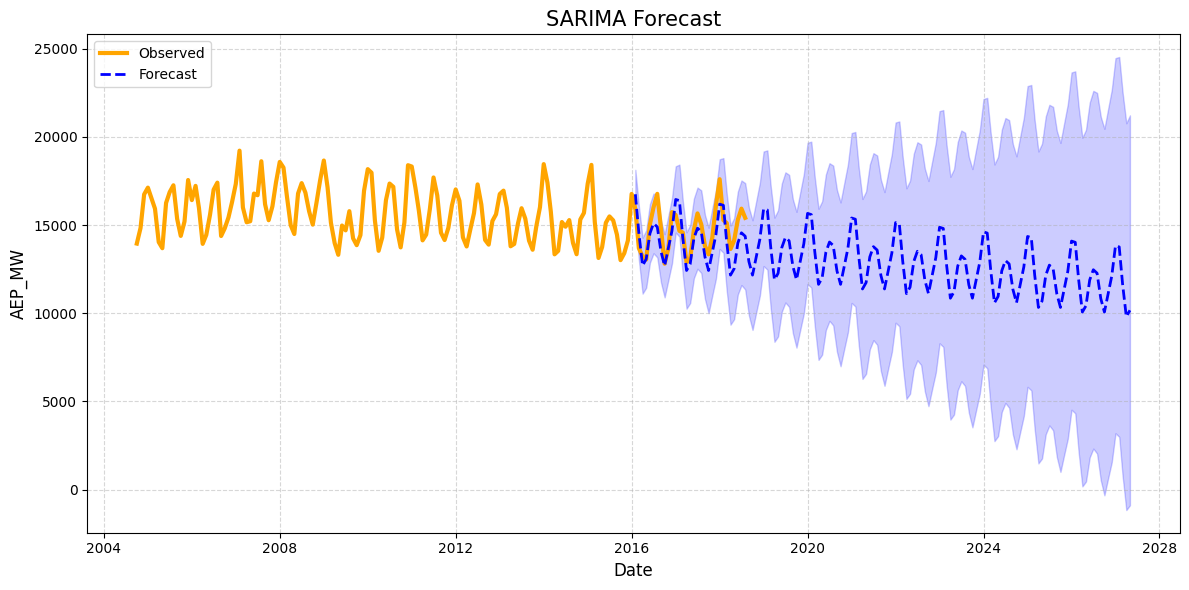

In [25]:
# Fit SARIMA model with differencing
model = SARIMAX(df_train['AEP_MW'], 
                order=(1, 1, 1),  # p, d, q for AR, differencing, MA
                seasonal_order=(1, 1, 1, 12),  # P, D, Q, m for seasonal components (12 for monthly data)
                enforce_stationarity=False, 
                enforce_invertibility=False)

# Fit model
model_fit = model.fit(disp=False)

# Print summary
print(model_fit.summary())

# Forecast future values
forecast_steps = len(df_train)
forecast = model_fit.get_forecast(steps=forecast_steps)

# Get the predicted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the training data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['AEP_MW'], label='Observed', color='orange', linewidth=3)
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='blue', linestyle='--', linewidth=2)
plt.fill_between(forecast_mean.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='blue', alpha=0.2)

plt.title('SARIMA Forecast', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AEP_MW', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

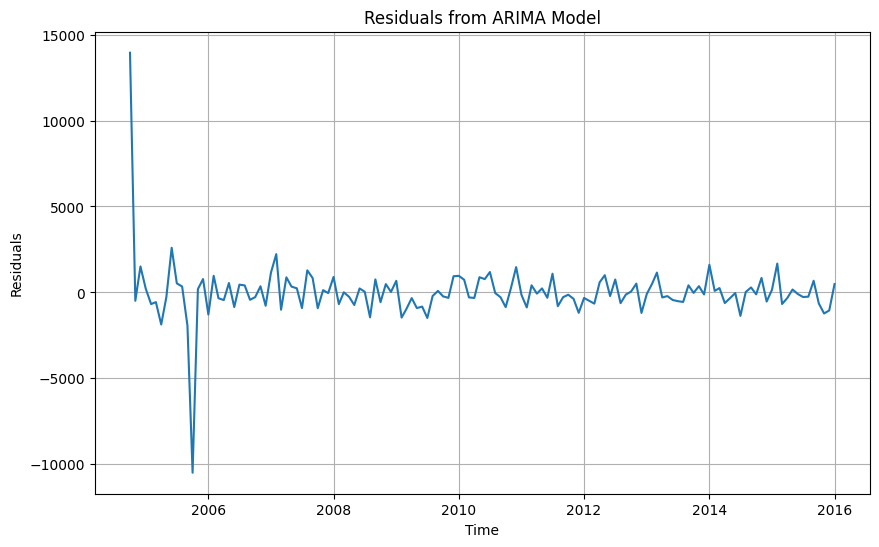

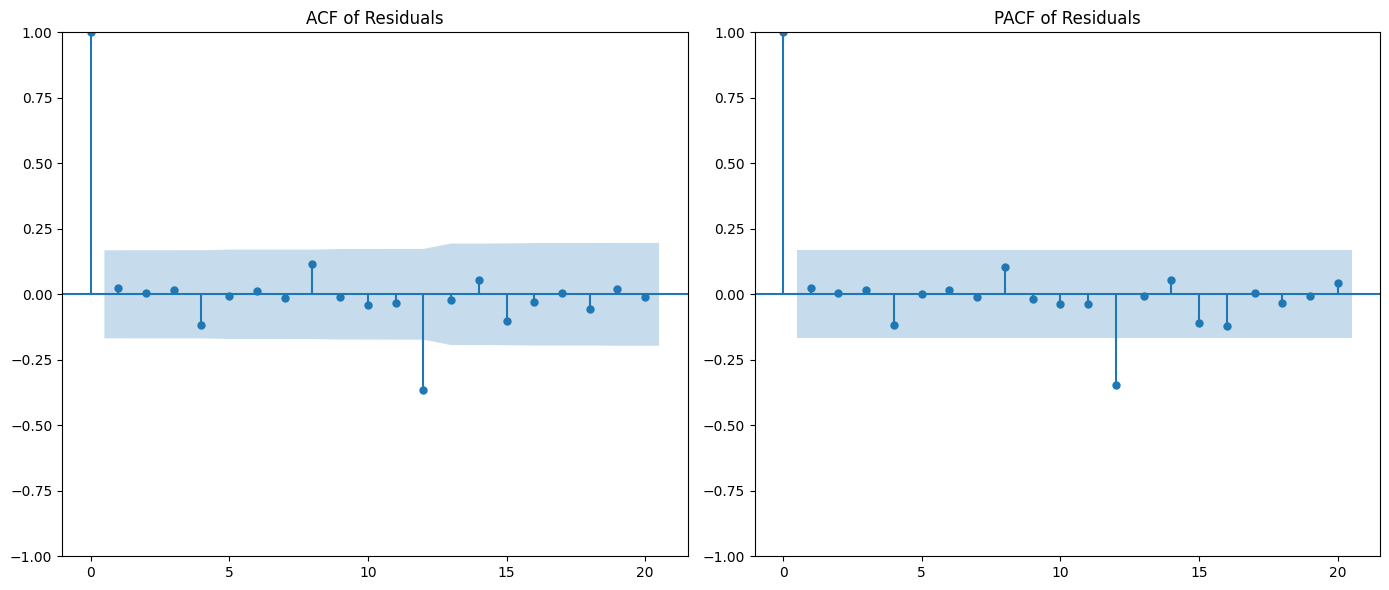

     lb_stat  lb_pvalue
10  4.404239   0.622145


In [26]:
# Calculate residuals
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(residuals.dropna(), lags=20, ax=axes[0])
axes[0].set_title('ACF of Residuals')
plot_pacf(residuals.dropna(), lags=20, ax=axes[1])
axes[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

# Ljung-Box Test
residuals = residuals.dropna()
lb_test = acorr_ljungbox(residuals, lags=[10], model_df=4, return_df=True)
print(lb_test)

This last one was the best fit (lowest AIC and highest p-value) so the cross validation is only applied on this one.

### 4.3 SARIMA Model 

In [27]:
warnings.filterwarnings("ignore")

# Define the number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize a list to store errors
errors = []

# Perform cross-validation
for train_index, test_index in tscv.split(df_train):
    train, test = df_train.iloc[train_index], df_train.iloc[test_index]
    
    # Fit the SARIMA model on the training data
    model = SARIMAX(train['AEP_MW'], 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 12), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # Forecast on the test set
    forecast = model_fit.forecast(steps=len(test))
    
    # Calculate error (e.g., RMSE)
    error = np.sqrt(mean_squared_error(test['AEP_MW'], forecast))
    errors.append(error)

# Calculate the average error across splits
mean_error = np.mean(errors)
print(f'Mean RMSE from Cross-Validation: {mean_error}')

Mean RMSE from Cross-Validation: 1080.2795475689707


This is considered pretty good, given the fact that the data ranges between 10000 and 25000.